/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


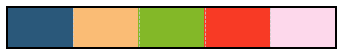

In [2]:
%load_ext autoreload
%autoreload 2

from runner import *
from process_results import *
import os
import pandas as pd
import matplotlib.pyplot as plt

fig_dir = os.path.expanduser("~") + "/repos/exchain-paper/figs"

import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : True})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
plt.rcParams['figure.figsize'] = 4, 3

# colors = ['#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#FCCDE5', '#8DD3C7', '#FFFFB3', '#BEBADA']
colors = ['#2A587A', '#FABC75', '#83B828', '#F83A25', '#FDD8EB']
# colors = ['#648FFF', '#FFB000', '#DC267F','#FE6100', '#785EF0']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 5, 1)
# sns.set_palette("ch:start=.2,rot=-.3")
line_style = dict(linewidth = 2, markersize = 8, err_style = "bars", dashes = False)
sub_figure_title = {"fontweight": 700, 'fontname':'Times New Roman', 'fontsize': 18}
plt.tight_layout()

In [3]:
table_data = []
result_data = []

for name, app in TEST_APPLICATIONS.items():
    table_data.append([])
    result_data.append([])
    table_data[-1].append(name.replace("_", "-").upper())
    result_data[-1].append(name.replace("_", "-").upper())
    ground_truth = app.read_ground_truth()
    dynamic_dependency = app.read_latest_dynamic_dependency()
    root_cause_in_log = check_root_cause_in_log(ground_truth, app.origin_log_path)
    table_data[-1].append(app.is_async)
    table_data[-1].append(root_cause_in_log)

    table_data[-1].append(get_exception_distance(ground_truth,
                                                   os.path.join(app.get_latest_result("dynamic"), "exception.json")))
    print(get_root_cause_location(ground_truth,
                                                   os.path.join(app.get_latest_result("dynamic"), "exception.json")))


    dynamic_result_path = app.get_latest_result("dynamic")
    exceptions = read_exceptions(os.path.join(dynamic_result_path, "exception.json"))
    table_data[-1].append(len(exceptions))
    ground_truth = app.read_ground_truth()
    dynamic_dependency = app.read_latest_dynamic_dependency()
    print(name)
    # for item in dynamic_dependency:
    #     print(item)
    # print(dynamic_dependency)


    static_dependency = app.read_latest_static_dependency()
    hybrid_online, hybrid_offline = app.read_latest_hybrid_dependency()
    result_data[-1].extend(process_dependency_result(hybrid_online + hybrid_offline, ground_truth))
    result_data[-1].extend(process_dependency_result(hybrid_online, ground_truth))
    result_data[-1].extend(process_dependency_result(hybrid_offline, ground_truth))
    result_data[-1].extend(process_dependency_result(static_dependency, ground_truth))

    result_data[-1].extend(process_dependency_result(dynamic_dependency, ground_truth))
save_as_latex_table(table_data, os.path.join(fig_dir, "issue_desc.tex"))
save_as_latex_table(result_data, os.path.join(fig_dir, "issue_result.tex"))

1
wicket_6908
java.lang.RuntimeException:model still attached!:org.apache.wicket.testapplication.TestPage/onBeforeRender:49 -> java.lang.RuntimeException:model still attached!:org.apache.wicket.testapplication.TestPage/onBeforeRender:49

java.lang.RuntimeException:model still attached!:org.apache.wicket.testapplication.TestPage/onBeforeRender:49 -> java.lang.RuntimeException:model still attached!:org.apache.wicket.testapplication.TestPage/onBeforeRender:49

org.apache.wicket.markup.MarkupException:Unable to find component with id 'renderCount' in [Page class = org.apache.wicket.testapplication.TestPage2, id = 1, render count = 1]	Expected: ':renderCount'.	Found with similar names: '':org.apache.wicket.markup.MarkupStream/throwMarkupException:534 -> java.lang.RuntimeException:model still attached!:org.apache.wicket.testapplication.TestPage/onBeforeRender:49

4
jena_324
12
tomcat_65131
50
fineract_1211
61
mapreduce_6654
42
nifi_8249
java.io.IOException:Could not obtain next record from R

In [5]:

table_data = []

perf_result = {}
for name, app in BENCH_APPLICATIONS.items():
    separate_results = ["fineract_bench", "jena_bench"]
    if "jena" in name:
        continue
    read_perf_result(app, perf_result)
for key, value in perf_result.items():
    print(key)
    df = pd.DataFrame(value, columns=["Application", "System", key.capitalize()])
    for sys in set(df["System"]):
        avg = 0
        for app in set(df['Application']):
            v = df[df['Application'] == app]
            v = v[v["System"] == sys]
            # print(app, sys, v[key.capitalize()].mean() - 1)
            avg += v[key.capitalize()].mean()
        avg /= 6
        print(sys, "avg", avg)



save_perf_data_to_pdf(perf_result, fig_dir)



latency
SI+Static avg 1.058549558257308
\sc{ExChain} avg 1.07842401145877
SI+Dynamic avg 21.519857829333887
throughput
SI+Static avg 0.9507831153752769
\sc{ExChain} avg 0.9469762699565605
SI+Dynamic avg 0.14684309585146876


<Figure size 576x288 with 0 Axes>

In [21]:

table_data = []

for name, app in TEST_APPLICATIONS.items():
    ground_truth = app.read_ground_truth()
    table_data.append([])
    table_data[-1].append(name.replace("_", "-").upper())
    t1 = open(os.path.join(app.out_path, "hybrid-results", "time.txt")).read().strip()
    t2 = open(os.path.join(app.out_path, "hybrid-results", "time.naive.txt")).read().strip()

    static_dependency = app.read_latest_naive_static_dependency()
    dynamic_dependency, _ = app.read_latest_hybrid_dependency()
    # print(static_dependency)
    # print(dynamic_dependency)
    result = (process_dependency_result(static_dependency + dynamic_dependency, ground_truth))
    print(result)
    print(name, t1, t2)
    table_data[-1].append(result[0])
    table_data[-1].append(float(t1))
    table_data[-1].append(float(t2))
save_as_latex_table(table_data, os.path.join(fig_dir, "static-cmp.tex"))

(True, 0)
wicket_6908 13.09579062461853 20.15886878967285
(True, 0)
jena_324 319.458904504776 233.07073307037354
(False, 0)
tomcat_65131 7.332220554351807 5.127790927886963
(False, 0)
fineract_1211 88.45979237556458 34.29286479949951
(True, 0)
mapreduce_6654 3613.968741416931 168.196307182312
(False, 0)
nifi_8249 367.45970153808594 236.90954613685608
(False, 0)
solr_16363 256.6314284801483 103.09499096870422
(True, 0)
hadoop_17812 464.4471251964569 690.8662927150726
(False, 0)
wicket_6249 8.13386082649231 11.791112184524536
(True, 0)
hdfs_4128 605.9486541748047 402.3261559009552
(True, 0)
hive_13410 5167.299909591675 2281.686991214752


/tmp/ipykernel_2361168/3339526115.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("./data/result.csv", header=0, sep=',\s+',)


        Name    Type     Ratio
0     HADOOP  assign  8.478420
1     HADOOP    call  2.619085
2     HADOOP  return  6.369375
3   FINERACT  assign  0.167793
4   FINERACT    call  2.305971
5   FINERACT  return  3.025453
6     WICKET  assign  1.442857
7     WICKET    call  1.604203
8     WICKET  return  4.979329
9       NIFI  assign  0.908752
10      NIFI    call  0.841363
11      NIFI  return  2.766091
12      JENA  assign  5.993027
13      JENA    call  2.667229
14      JENA  return  3.477916
15    TOMCAT  assign  2.923520
16    TOMCAT    call  2.280900
17    TOMCAT  return  8.418938
18      SOLR  assign  2.466059
19      SOLR    call  1.867025
20      SOLR  return  4.606708
21      HIVE  assign  3.922401
22      HIVE    call  3.993683
23      HIVE  return  3.819853


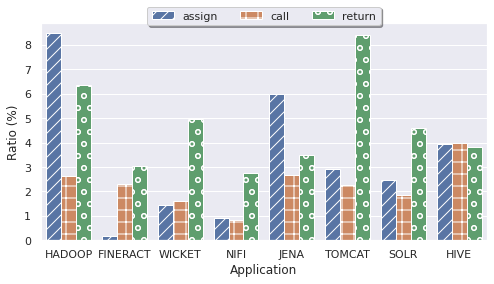

In [2]:
data = pd.read_csv("./data/result.csv", header=0, sep=',\s+',)
data["Name"] = data["Name"].str.upper()
plt.rcParams['figure.figsize'] = 8, 4
draw_dist(data, os.path.join(fig_dir, "app-dist.pdf"))
print(data)


In [23]:

table_data = []

perf_result = {}
for name, app in BENCH_APPLICATIONS.items():
    read_perf_result(app, perf_result, ["origin", "static", "origin-debug", "hybrid", "origin-noopt", "dynamic"], False, False)
for key, value in perf_result.items():
    df = pd.DataFrame(perf_result[key], columns=["Application", "System", "Latency"])
    df = df.groupby(["Application", "System"]).mean()
    df["Latency"] -= 1
    if key != "latency":
        df["Latency"] = -df["Latency"]
    df["Latency"] *= 100
    print(df)
    pivot_df = df.pivot_table(values='Latency', index=['Application'], columns=['System'])
    pivot_df["Local"] = pivot_df['dynamic'] - pivot_df['static']
    pivot_df["JVMTi"] = pivot_df['origin-debug']
    pivot_df["Logging"] = pivot_df["static"] - pivot_df['origin-debug']
    pivot_df["Inst"] = pivot_df["origin-noopt"] - pivot_df['static']
    pivot_df["Taint"] = pivot_df["hybrid"] - pivot_df['origin-noopt']
    pivot_df = pivot_df.drop(["hybrid", "static", "origin-debug", "hybrid", "origin-noopt", "dynamic"], axis=1)
    print(pivot_df)
    pivot_df[pivot_df < 0] = 0
    pivot_df = pivot_df.unstack().reset_index()
    save_stacked_perf_to_pdf(pivot_df, os.path.join(fig_dir, f"stacked-{key}.pdf"), key.capitalize())

                              Latency
Application System                   
FINERACT    dynamic       4011.216313
            hybrid          10.802154
            origin-debug     2.912018
            origin-noopt     9.416541
            static           4.849061
HADOOP      dynamic         87.049431
            hybrid           7.813604
            origin-debug     0.085134
            origin-noopt     4.030220
            static           0.119402
HDFS        dynamic        424.041496
            hybrid          13.158971
            origin-debug     1.776739
            origin-noopt     4.196376
            static           2.352425
MAPREDUCE   dynamic       5015.419885
            hybrid          11.272570
            origin-debug    13.562967
            origin-noopt     7.462452
            static           9.595066
TOMCAT      dynamic       1758.627136
            hybrid          13.437555
            origin-debug     2.135455
            origin-noopt    11.940729
            

<Figure size 576x288 with 0 Axes>